# Assignment 8: Space charge map implementation -- Solution

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px">
        <ul>
            <li>Implement the space charge map in drift and quadrupole.</li>
            <li>Track the beam through a FODO cell with & without space charge considered.</li>
            <li>Compare the beam envelope.</li>
            <li>Check the stability criterion.</li>
            </ul>
    </div>
</html>

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>If you use google colab, run this cell:</strong>
    </div>
</html>

In [ ]:
# for google colab, run this cell
!git clone https://github.com/potato18z/pam1-hs2021.git
import sys
sys.path.append('./pam1-hs2021')

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
<strong>If you run it locally, run</strong>
               </div>
</html>

```bash
$ cd .../pam1-hs2021
...pam1-hs2021$ git pull
```
<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
to get the updated repository.</div></html>

## Initialization
<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px">
        <ul>
            <li> Simply run this cell to instantiante an `Electron` species and set all global variables in the `Parameter` module. Take 3 MeV as the kinetic energy. </li>
        </ul>
    </div>
</html>

In [1]:
import numpy as np
import AcceLEGOrator.Parameter as param
from AcceLEGOrator import Proton, Constants, Physics
from AcceLEGOrator import Gaussian, Bunch
import matplotlib.pyplot as plt
import copy

c = Constants.clight

Ekin = 3 # MeV

proton = Proton()

# set global variables
param.gamma_0 = Physics.getGamma(Ekin, proton.mass)
param.mass = proton.mass # MeV / c^2
param.charge = proton.charge # e

beta0 = Physics.getBeta(param.gamma_0)
p0 = param.gamma_0 * beta0 * param.mass   # MeV / c
Brho = p0 / param.charge * 1e6 / c # T*m

print('gamma =', param.gamma_0)
print('beta  =', beta0)
print('p0    =', p0 , 'MeV/c')
print('Br    =', Brho, 'Tm')

gamma = 1.0031973667743683
beta  = 0.07977590058404604
p0    = 75.09082852758958 MeV/c
Br    = 0.25047604275485 Tm


<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px">
        <ul>
            <li> Simply run this cell to define the test FODO cell.</li>
        </ul>
    </div>
</html>

![fodo_for_sc](img/fodo_for_sc.png)

In [2]:
from AcceLEGOrator import Drift, Quadrupole
# quadrupole length [m]
Lq = 0.05

# quandrupole strength [1/m^2]
kq = 400.0

# magnetic field gradient [T/m]
gradBf = kq * Brho

# half focusing quadrupole
Qf = Quadrupole(Lq, gradBf)

print('focusing Quadrupole:', Qf)

# magnetic field gradient [T/m]
gradBd = -kq * Brho

# defocusing quadrupole
Qd = Quadrupole(Lq, gradBd)

print('defocusing Quadrupole:', Qd)

# drift length [m]
Ldr = 0.05

# drift
Dr_h = Drift(Ldr/2.) # half drift
Dr = Drift(Ldr)

print('half drift:', Dr_h)
print('drift:', Dr)

# define FODO cell
fodo = [Dr_h, Qf, Dr, Qd, Dr_h]

# collect fodo parameters together
fodo_params = {'Lq':Lq, 
               'gradBf': gradBf,
               'gradBd': gradBd,
               'Ldr': Ldr}

focusing Quadrupole: Quadrupole(L = 0.05 [m], grad B = 100.19041710194001 [T/m])

defocusing Quadrupole: Quadrupole(L = 0.05 [m], grad B = -100.19041710194001 [T/m])

half drift: Drift(L = 0.025 [m])

drift: Drift(L = 0.05 [m])



<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ul>
            <li>Use the `getMatchedSigma` function in `Tracking.py` to calculate the the sigma matrix that is matched to the fodo cell. </li>
            <li>We assume an normalised rms emittance of $\epsilon_{rms,x}=\epsilon_{rms,y}=0.3 [mm\cdot mrad] = 0.3 \cdot 10^{-6}[m\cdot rad]$. To get the geometric rms emittance, we need to divide it by $\beta\gamma$.</li>
            <li>Define a Gaussian beam of $N=10^7$ protons using the matched sigma.</li>
        </ul>
    </div>
</html>

In [3]:
from AcceLEGOrator import Tracking

emit = 0.3/(beta0*param.gamma_0)*1e-6 # m*rad
sigma_matched = Tracking.getMatchedSigma(cell=fodo, ex=emit, ey=emit)

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
           <ul>
            <li>Use the `trackSigma` function in `Tracking.py` to track the sigma matrix for $n_{cells}=4$. </li>
            <li>Plot the rms beam sizes in x and y. The parameter `n_slice` cuts each element (except drift) into shorter slices to get a smoother output. Change $n_{slice}$ from 1 and see the difference. The result should be quite ok for $n_{slice}> 5$.</li>
            <li>Check if you can reproduce the plot on Page 22 of `pam-s8.pdf`.</li>
        </ul>
    </div>
</html>

You can check the `_sliceMap()` function in `Tracking.py` to see how `get()` function works.

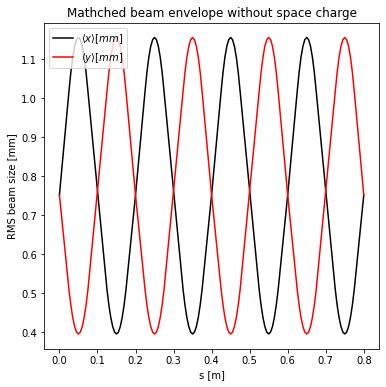

In [4]:
all_sigmas_matched, lengths = Tracking.trackSigma(sigma_matched, cell=fodo, n_cells=4, n_slice=10)

# plot
fig = plt.figure()
fig.set_size_inches(6,6)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel('RMS beam size [mm]')

axis.plot(lengths, np.sqrt(all_sigmas_matched[:,0,0])*1e3, label=r'$\langle x\rangle [mm]$', color='black')
# note that the original unit is [m] and here we want [mm]
axis.plot(lengths, np.sqrt(all_sigmas_matched[:,2,2])*1e3, label=r'$\langle y\rangle [mm]$', color='red')

axis.legend(loc='upper left')
plt.title('Mathched beam envelope without space charge')
plt.show()

## Space charge map - general solution for various elements
From equation (23) of `pam-s7` we can derive that for a drift
$$
x'' - \frac{K}{r_0^2}x = 0,\quad\quad y''- \frac{K}{r_0^2}y = 0.
$$
where $(\cdot)' = \frac{d(\cdot)}{ds}$, perveance $K = \frac{qI}{2\pi\varepsilon_0 m_0 c^3\beta^3\gamma^3}$ and $r_0$ is the radius of a uniformly distributed circular beam.

From equation (24) of `pam-s7` we know that for a quadrupole focusing in $x$ direction
$$
\begin{align}
x'' + k_1x - \frac{K}{r_0^2}x &= 0,\\
y'' - k_1y - \frac{K}{r_0^2}y &= 0.
\end{align}
$$
where $k_1 = \frac{q}{P_0}\cdot gradB$ is the normalised quadrupole gradient.

We can write the above equations into a generalised form
$$
u''(s) + C\cdot u(s) = 0
$$
where $u=x$ or $y$, and C takes different values according to different elements.


<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ul>
            <li> Check that we can write a general solution to the above ODE.</li>
$$
u(s) = c_1\cdot\cos\left(\sqrt{C}s\right) + c_2\cdot\sin\left(-\sqrt{C}s\right)
$$
where $C$ could be negative and $\sqrt{C}$ could be complex.
        </ul>
    </div>
</html>

It's easy to check that this general solution is correct.
$$
\begin{align}
u'(s) &= -\sqrt{C}\cdot c_1\cdot\sin\left(\sqrt{C}s\right) - \sqrt{C} \cdot c_2\cdot\cos\left(\sqrt{C}s\right) \\
u''(s) &= -C\cdot c_1\cdot\cos\left(\sqrt{C}s\right) + C\cdot c_2\cdot\sin\left(\sqrt{C}s\right) \\ 
&= -C\cdot c_1\cdot\cos\left(\sqrt{C}s\right) - C\cdot c_2\cdot\sin\left(-\sqrt{C}s\right) \\ 
&= -C\cdot u(s)
\end{align}
$$

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ul>
            <li>Derive the linear map of space charge for an element of length $L$.
            <li>in horizontal directions (i.e. a $4\times 4$ map). In longitudinal direction we neglect the space charge force.</li>
        </ul>
    </div>
</html>

From above we get the momentum equation

$$
u'(s) = -\sqrt{C}\cdot c_1\cdot\sin\left(\sqrt{C}s\right) - \sqrt{C} \cdot c_2\cdot\cos\left(\sqrt{C}s\right)
$$

Therefore using initial state at $s = 0$ and final state at $s = L$, we obtain
$$
\begin{align}
u(0) &= c_1, \\
u(L) &= c_1\cdot\cos\left(\sqrt{C}L\right) + c_2\cdot\sin\left(-\sqrt{C}L\right), \\
u'(0) &= -\sqrt{C}\cdot c_2, \\
u'(L) &= -\sqrt{C}\cdot c_1\cdot\sin\left(\sqrt{C}L\right) - \sqrt{C} \cdot c_2\cdot\cos\left(\sqrt{C}L\right).
\end{align}
$$

This simplifies to
$$
\begin{align}
u(L) &= u(0)\cdot\cos\left(\sqrt{C}L\right) - \frac{u'(0)}{\sqrt{C}}\cdot\sin\left(-\sqrt{C}L\right)=u(0)\cdot\cos\left(\sqrt{C}L\right) + \frac{u'(0)}{\sqrt{C}}\cdot\sin\left(\sqrt{C}L\right), \\
u'(L) &= -\sqrt{C}\cdot u(0)\cdot\sin\left(\sqrt{C}L\right) +u'(0)\cdot\cos\left(\sqrt{C}L\right).
\end{align}
$$

In matrix notation
$$
\begin{pmatrix}u \\ u'\end{pmatrix}^L =
\begin{pmatrix}\cos\left(\sqrt{C}L\right) & \frac{\sin\left(\sqrt{C}L\right)}{\sqrt{C}} \\
-\sqrt{C}\sin\left(\sqrt{C}L\right) & \cos\left(\sqrt{C}L\right) \end{pmatrix}\cdot
\begin{pmatrix}u \\ u'\end{pmatrix}^0.
$$
This has the same format as quadrupole map.

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ul>
            <li>Define the space charge map for drift and quadrupole using the previous result in the horizontal directions. In longitudinal direction we neglect the space charge force.</li>
        </ul>
    </div>
</html>

#### Notes
- You can get inspiration from the original definition of Drift and Quadrupole maps in `Map.py`.
- When calculating $I_0$, keep in mind that our proton.mass already has the unit of $MeV/c^2$.
- `np.lib.scimath.sqrt` is used here instead of the usual `np.sqrt` to handle complex cases. Pay close attention to the sign of $C$.
- In the case of a uniformly distributed circular beam of radius $r_0$, there is the beam area $\pi r_0^2$ inside the denominator of the space charge term. Since our beam is
    - Gaussian,
    - although it starts from a 'circle' in $x$ and $y$, it grows to become ellipses during the evolution
  
  We need to find a proper way to estimate the action area of space charge. Since the area of ellipse is $\pi ab$,  we simply use here $\sqrt{\langle x^2\rangle}$ and $\sqrt{\langle y^2\rangle}$ to approximate $a$ and $b$, i.e. $r_0^2 \sim \sqrt{\langle x^2\rangle\cdot \langle y^2\rangle}$.

In [5]:
from AcceLEGOrator import Map, Physics, Constants
import numpy as np
import scipy.constants as sc

class SpaceChargeDrift(Map):
    
    # param length: element length [m]
    # param sigma: the sigma matrix of the bunch being tracked
    # param I_sc: beam current for evaluating space charge [A]
    def __init__(self, length, sigma, I_sc):
        self.length = length
        self.__sigma = sigma
        beta_0 = Physics.getBeta(param.gamma_0)
       
        eps0 = Constants.epsilon0
        c    = Constants.clight
        e    = Constants.echarge
        q    = param.charge * e # [C]
        
        self.I = I_sc
        self.I0 = 4 * np.pi * eps0 * param.mass * c / param.charge * 1e6 # unit [A], page 14 pam-s7
        self.K = self.I / self.I0 * 2.0 / (beta_0 * param.gamma_0) ** 3 # equation (22), pam-s7
        
        r02 = np.sqrt(sigma[0,0]*sigma[2,2]) # use the product of rms beam sizes to estimate beam area
        
        C = - self.K/r02

        w = np.lib.scimath.sqrt(C)
            
        cs  = np.cos(w * length)
        s   = np.sin(w * length)
        f   = length / (beta_0 * param.gamma_0 ) ** 2
        
        R = np.real_if_close(np.matrix(
            [[cs,      s/w,    0,      0,      0,  0],
            [-w*s,     cs,     0,      0,      0,  0],
            [0,        0,      cs,     s/w,    0,  0],
            [0,        0,      -w*s,   cs,     0,  0],
            [0,        0,      0,      0,      1,  f],
            [0,        0,      0,      0,      0,  1]], dtype = 'complex_'))
        super(SpaceChargeDrift, self).__init__(R, length)
    
    
    def __str__(self):
        return 'SpaceChargeDrift(I = ' + str(self.I) + ' [A],\n'\
               + '\t\t      I_0 = ' + str(self.I0) + '[A])\n'\
               + '\t\t      K = ' + str(self.K) + ')\n'\
               + '\t\t      length = ' + str(self.length) + '[m]'
    
    def get(self, length, sigma=None):
        # return another SpaceChargeDrift with different sigma and/or length
        if sigma is None:
            return SpaceChargeDrift(length, self.__sigma, self.I)
        else:
            return SpaceChargeDrift(length, sigma, self.I)

In [6]:
class SpaceChargeQuadrupole(Map):
    
    # param length in [m]
    # param gradB in [T/m]
    # param sigma: the sigma matrix of the bunch being tracked
    # param I_sc: beam current for evaluating space charge [A]
    def __init__(self, length, gradB, sigma, I_sc):
        self.length = length
        self.__gradB = gradB
        self.__sigma = sigma
        beta_0 = Physics.getBeta(param.gamma_0)
        
        eps0 = Constants.epsilon0
        c    = Constants.clight
        e    = Constants.echarge
        q    = param.charge * e # [C]
        
        P_0 = param.mass * 1e6 / c * param.gamma_0 * beta_0
        k_1 = param.charge / P_0 * self.__gradB
        
        self.I = I_sc
        self.I0 = 4 * np.pi * eps0 * param.mass * c / param.charge * 1e6 #[A]
        self.K = self.I / self.I0 * 2.0 / (beta_0 * param.gamma_0) ** 3

        r02 = np.sqrt(sigma[0,0]*sigma[2,2])
        
        C_x = k_1 - self.K/r02
        C_y = -k_1 - self.K/r02
        
        w_x = np.lib.scimath.sqrt(C_x)
        w_y = np.lib.scimath.sqrt(C_y)
            
        cs_x  = np.cos(w_x * length)
        s_x   = np.sin(w_x * length)
        cs_y = np.cos(w_y* length)
        s_y  = np.sin(w_y * length)
        
        f   = length / (beta_0 * param.gamma_0 ) ** 2
        
        R = np.real_if_close(np.matrix(
            [[cs_x,    s_x/w_x,    0,      0,      0,  0],
            [-w_x*s_x,      cs_x,    0,      0,      0,  0],
            [0,        0,      cs_y,    s_y/w_y,    0,  0],
            [0,        0,      -w_y*s_y,    cs_y,    0,  0],
            [0,        0,      0,      0,      1,  f],
            [0,        0,      0,      0,      0,  1]], dtype = 'complex_'))
        
        super(SpaceChargeQuadrupole, self).__init__(R, length)
    
    
    def __str__(self):
        return 'SpaceChargeQuadrupole(I = ' + str(self.I) + ' [A],\n'\
               + '\t\t      I_0 = ' + str(self.I_0) + '[A])\n'\
               + '\t\t      K = ' + str(self.K) + ')\n'\
               + '\t\t      gradB = ' + str(self.__gradB) + '[T/m]\n'\
               + '\t\t      length = ' + str(self.length) + '[m]'

    def get(self, length, sigma=None):
        # return another SpaceChargeQuadrupole with different sigma and/or length
        if sigma is None:
            return SpaceChargeQuadrupole(length, self.__gradB, self.__sigma, self.I)
        else:
            return SpaceChargeQuadrupole(length, self.__gradB, sigma, self.I)

## Tracking through space charge incorporated FODO cells
<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px">
        <ul>
            <li> Simply run this cell to define space charge incorporated FODO cell.</li>
        </ul>
    </div>
</html>

In [7]:
def get_fodo_sc(fodo_params, sigma, I):  
    # FODO parameters
    Lq = fodo_params['Lq']
    gradBf = fodo_params['gradBf']
    gradBd = fodo_params['gradBd']
    Ldr = fodo_params['Ldr']

    # define the space charge FODO cell
    # focusing quadrupole
    Qf_sc = SpaceChargeQuadrupole(Lq, gradBf, sigma, I)

    # defocusing quadrupole
    Qd_sc = SpaceChargeQuadrupole(Lq, gradBd, sigma, I)

    # drift
    Dr_h_sc = SpaceChargeDrift(Ldr/2., sigma, I) # half drift
    Dr_sc = SpaceChargeDrift(Ldr, sigma, I)

    # define space charge FODO cell
    fodo_sc = [Dr_h_sc, Qf_sc, Dr_sc, Qd_sc, Dr_h_sc]
    return fodo_sc

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ul>
            <li>Define the following function to track sigma through space charge incorporated FODO beamline.</li>
        </ul>
    </div>
</html>

#### Notes
- Since sigma is changing throughout tracking, we need to update sigma and the accelerator elements together. For example, to track sigma through [drift, quadrupole]
    - progagate sigma through drift;
    - collect the sigma after drift;
    - use the new sigma to define a new quadrupole; **Use the get() function here**
    - propagate sigma through the new quadrupole
    - collect the sigma after quadrupole.
  
  Note that the above process should loop over each **slice** of acclerator element. Each slice of M has length $M.length/n_{slice}$.

In [8]:
def track_fodo_sc(fodo_sc, sigma, n_cells=1, n_slice=1):
    # initial sigma
    sigmas = np.expand_dims(sigma, axis=0)
    
    # initial length
    length_till_now = 0.
    lengths = [0,]

    cells = {} # this is to collect the updated FODO cells
    for n in range(n_cells):
        cells[n] = []
        for M in fodo_sc:
            L = M.length
            for i in range(n_slice):
                # use the current sigma to define slice i map
                M_slice_i = M.get(length=L/n_slice, sigma=sigma)

                # calculate length
                length_till_now = length_till_now + M_slice_i.length
                lengths.append(length_till_now)

                # propagate sigma using M_slice_i
                sigma = M_slice_i * sigma * M_slice_i.T

                # collect sigma
                sigmas = np.append(sigmas, np.expand_dims(sigma, axis=0), axis=0)

                # collect maps
                cells[n].append(M_slice_i)
    return sigmas, lengths, cells

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ul>
            <li>Track the sigma matrix through the space charge incorprated FODO cell for different beam current $I=0mA$, $60mA$ and $300mA$. Compare your result with page 23 of `pam-s8`.</li>
        </ul>
    </div>
</html>

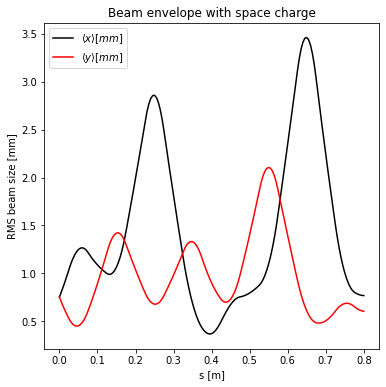

In [9]:
fodo_sc = get_fodo_sc(fodo_params, sigma_matched, I=0.375) # I has unit [A], change I to test stability
all_sigmas_sc, lengths_sc, cells_sc = track_fodo_sc(fodo_sc, sigma_matched, n_cells=4, n_slice=10)
# plot
fig = plt.figure()
fig.set_size_inches(6,6)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel('RMS beam size [mm]')

axis.plot(lengths_sc, np.sqrt(all_sigmas_sc[:,0,0])*1e3, label=r'$\langle x\rangle [mm]$', color='black')
axis.plot(lengths_sc, np.sqrt(all_sigmas_sc[:,2,2])*1e3, label=r'$\langle y\rangle [mm]$', color='red')

axis.legend(loc='upper left')
plt.title('Beam envelope with space charge')
plt.show()

## Stability analysis

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>TODO:</strong>
        <ul>
            <li>Based on the BIBO stability criterion given on Page 85 of `pam-s5`, what is the stability limit, i.e. the maximal current ($I_{max}$) such that the beam is still stable?</li>
        </ul>
    </div>
</html>

In [10]:
cell = cells_sc[0]#fetch the updated FODO_sc cell here. Since we track 4 cells, the indices you can take are 0,1,2,3
M_fodo_sc = Tracking.getMcell(cell=cell)
# calculate stability
tr_h = M_fodo_sc[0,0] + M_fodo_sc[1,1] # horizontal phase space
tr_v = M_fodo_sc[2,2] + M_fodo_sc[3,3] # vertical phase space

print('Horizontal |trace| of M_cell is:', abs(tr_h))
print('Vertical |trace| of M_cell is:', abs(tr_v))

Horizontal |trace| of M_cell is: 1.9948200181210356
Vertical |trace| of M_cell is: 1.0391232235919303


By changing $I$ in function `get_fodo_sc` in the previous cell, we find that with I=375mA, in horizontal space the trace almost reaches 2.

## Bonus (Open questions)
- Besides Gaussian, define a elliptical bunch following uniform distribution. Instead of simply drawing the ellipse from parameters $a$ and $b$, we need to define the elliptical bunch according to its sigma matrix.
  
  Thoughts: In 1-dimensional case, if we use sigma[0,0] as var(x) and 0 as mean(x), we would get the lower and upper limits of uniform distribution: $[-\sqrt{3\sigma_{0,0}}, \sqrt{3\sigma_{0,0}}]$. But if we do this for all 6 dimensions, we would get a cube instead of an ellipse. Discarding particles outside the ellipse would then change the number of particles and also the sigma, not to mention that we still don't know the envelope of our desired ellipse yet.
  
- If an uniformly distributed ellipse is successfully defined, we can use equation (21) of [1] to calculate the space charge.

## References
- [1] K. Schindl, Space Charge, https://cds.cern.ch/record/941316/files/p305.pdf
- [2] L.Hein, CERN Linac4 - The Space Charge Challenge, https://cds.cern.ch/record/1626566
- [3] B.Holzer, Lattice Design in Particle Accelerators II, https://indico.cern.ch/event/103406/contributions/20657/attachments/11961/17473/CAS_Holzer_II.pdf
- [4] Emittance Diagnostics, https://cas.web.cern.ch/sites/default/files/lectures/dourdan-2008/braun-emittance.pdf